# Test Notebook for various data files

This notebook contains tests for:   
    - pyspch.timit.read_seg_file()   
    - pyspch.read_data_file()   or read_txt() 
    - pyspch.read_data_frame()

*read_seg_file()* is a segmentation reading routine included with a lot of other TIMIT related definitions   

*read_txt()* is suitable for importing corpus style files

Note: in many cases the simpler load_data() may be  applicable

01/04/2022: verified with v0.6.3   
19/04/2022: verified with v0.6.5
27/09/2022: v0.7

In [3]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [4]:
%matplotlib inline
import os,sys,io 
import scipy.signal
import pkg_resources

from urllib.request import urlopen
from IPython.display import display, Audio, HTML, clear_output
from ipywidgets import interact

import math,time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

import librosa as librosa
    
import pyspch.sp as Sps
import pyspch.display as Spd
import pyspch.core as Spch

## File Objects

pyspch provides generic (read) access to files (locally, mounted, via URL) via
- open_fobj(): opens any file like objects
- read_fobj(): reads data from any file like object in a FILE IO object in raw format
- read_data_file(): reads text data from any file like object (default=list of lines)
- read_data_frame(): reads a TAB separated data file
- load(): loads audio from any file like object

### Example 1: read file included in the package into list of lines using native Python

In [5]:
name = 'mini_corpus.lst'
# filename = '../pyspch/data/' + name   # this only works on local installs
filename = pkg_resources.resource_filename('pyspch','data/' + name)
f = open(filename)
f.read().splitlines()

['friendly      0.0   -1.  friendly computers',
 'beed          0.0   -1.  beed bad booed',
 'f1            0.1  1.30  misinterpret ',
 'f1            1.3  2.7  expansionist ',
 'f1            2.80 3.7  circumspect']

### Example 2: read_data_file() to read local or remote files

- Reads local or remote files into list of lines
- optionally splits each line on whitespace in a max of maxcols+1

In [6]:
fname = 'mini_corpus.lst'
root ='HTTPS://homes.esat.kuleuven.be/~spchlab/data/misc/'
#
# read_fobj() would just read the raw data, unencoded
# data = Spch.read_fobj(root+fname)
#
data_split = Spch.read_data_file(root+fname,maxcols=3)
data = Spch.read_data_file(root+fname)
data, data_split

(['friendly      0.0   -1.  friendly computers',
  'beed          0.0   -1.  beed bad booed',
  'f1            0.1  1.30  misinterpret',
  'f1            1.3  2.7  expansionist',
  'f1            2.80 3.7  circumspect'],
 [['friendly', '0.0', '-1.', 'friendly computers'],
  ['beed', '0.0', '-1.', 'beed bad booed'],
  ['f1', '0.1', '1.30', 'misinterpret'],
  ['f1', '1.3', '2.7', 'expansionist'],
  ['f1', '2.80', '3.7', 'circumspect']])

### Example 3: read_dataframe() to read column oriented files

- Reads local or remote files into a DataFrame
- is a wrapper around pd.read_csv() with useful presets and options
    + assumes no header
    + tab delimited by default, but can handle any sep
    + strip=True strips white space at edges from a string datafield 
    + does a reasonable automatic data type casting
    + ...

In [7]:
fname = 'mini_corpus.txt'
root = '../pyspch/data/'
root ='HTTPS://homes.esat.kuleuven.be/~spchlab/data/misc/'
corpus = Spch.read_dataframe(root+fname,names=['file','t0','t1','text'],strip=True)
corpus.dtypes, corpus

(file     object
 t0      float64
 t1      float64
 text     object
 dtype: object,
        file   t0   t1                text
 0  friendly  0.0 -1.0  friendly computers
 1      beed  0.0 -1.0      beed bad booed
 2        f1  0.1  1.3        misinterpret
 3        f1  1.3  2.7        expansionist
 4        f1  2.8  3.7         circumspect)

In [8]:
# read a segmentation datafile
root='https://homes.esat.kuleuven.be/~spchlab/data/timit/'
file = "audio/train/dr1/fcjf0/si1027"
# get segmentations
segwrd = Spch.read_dataframe(root+file+ ".wrd",names=['t0','t1','seg'],sep='\s+')
print(segwrd.dtypes)
segwrd

t0      int64
t1      int64
seg    object
dtype: object


,t0,t1,seg
0,1513,7436,even
1,7436,12338,then
2,12338,16041,if
3,16041,18300,she
4,18300,22500,took
5,22500,24522,one
6,24522,28120,step
7,28120,34882,forward
8,34882,36920,he
9,36920,39160,could


### Reading TIMIT transcriptions files

In [9]:
fn1 = 'audio/train/dr1/fcjf0/sa1.txt'
root='https://homes.esat.kuleuven.be/~spchlab/data/timit/'
transcript = Spch.read_data_file(root+fn1)[0].strip().split(None,2)
print('Samples: ',int(transcript[0]),int(transcript[1]))
print('Transcript: ',transcript[2].strip('.,!?:;'))

Samples:  0 46797
Transcript:  She had your dark suit in greasy wash water all year


### Reading Mapping files and converting to dictionary

In [10]:
fn1="conf/phones-61-48-39-41.txt"
root='https://homes.esat.kuleuven.be/~spchlab/data/timit/'
transcript = Spch.read_data_file(root+fn1)
cols = Spch.read_data_file(root+fn1, maxcols = 4)
dict(zip(cols[0],cols[3]))

{'aa': 'ao'}

## (TIMIT) Segmentation Files

Segmentation Files are assumed to be in the format

t0  t1   seg    
....


#### time units
t0, t1 are begin and end-times of segment 'seg'
the units of time, can be specified in the read_seg_file() module with 'dt', by default segmentation times are given in seconds;
in timit it is often in samples (with SR=16000), thus use dt=1/16000

#### phonetic symbols
Phonetic transcriptions come in a variety of phonetic symbol sets.
These utilities include default definitions (and orderings) of **TIMIT48** and **TIMIT41**.   TIMIT48 is the default used in experiments with TIMIT.   TIMIT41 is our own more compact version inspired by the alphabet in the CMU dictionaries, with 1 additional closure ('cl') symbol.

A number of mappings between the different alphabets are foreseen.  To apply them use the field 'xlat' at time of reading and specify the desired translation:  timit61_48, timit61_41, ..
These are simple dictionary based mappings.   

In [11]:
# read a datafile
root='https://homes.esat.kuleuven.be/~spchlab/data/timit/'
file = "audio/train/dr1/fcjf0/si1027" #@param {type:"string"}
wavfile = root+file+".wav" 
wavdata, sr = Spch.audio.load(wavfile)
spg1 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)

# get segmentations
segwrd = Spch.timit.read_seg_file(root+file+ ".wrd",dt=1/sr,fmt='float32')
segphn61 = Spch.timit.read_seg_file(root+file+ ".phn",dt=1/sr,fmt='float32')
segphn = Spch.timit.read_seg_file(root+file+ ".phn",dt=1/sr,fmt='float32',xlat='timit61_41')

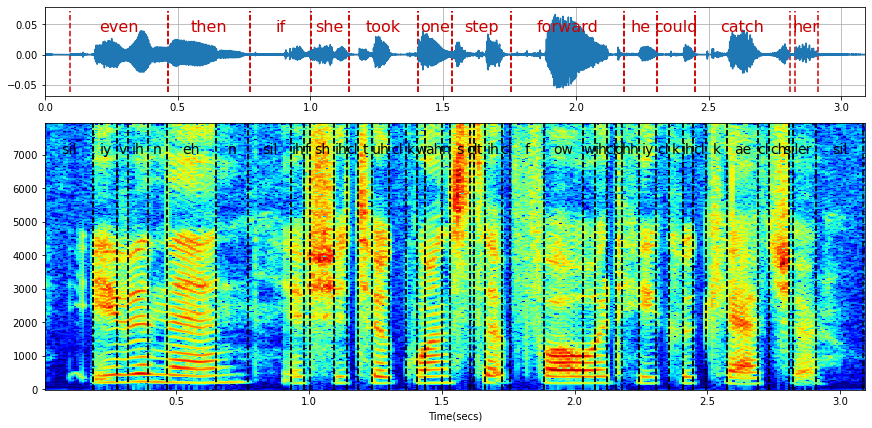

In [12]:
fig = Spd.PlotSpg(spg1,wavdata=wavdata,segwav=segwrd,segspg=segphn,sample_rate=sr)
display(fig)
display(Audio(data=wavdata,rate=sr))